In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

2026-02-08 19:44:42.300985: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model = load_model("../models/efficient_net_classifier.keras")
model.summary()

In [3]:
def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img)
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0

    return img

In [ ]:
img_path = "../data/processed/COVID/images//COVID-1000.png" 
img = preprocess_image(img_path)
input_tensor = tf.expand_dims(img, axis=0)


In [37]:
grad_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=[
        model.get_layer("top_conv").output,
        model.output
    ]
)

In [38]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(input_tensor)
    loss = predictions
    grads = tape.gradient(loss, conv_outputs)

In [39]:
# Global average pooling on gradients
weights = tf.reduce_mean(grads, axis=(0, 1, 2))

# Weighted sum of feature maps
cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)

# Normalize
cam = tf.maximum(cam, 0)
cam = cam / tf.reduce_max(cam)

In [40]:
cam = cv2.resize(cam.numpy(), (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

original = (img.numpy() * 255).astype(np.uint8)
overlay = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)

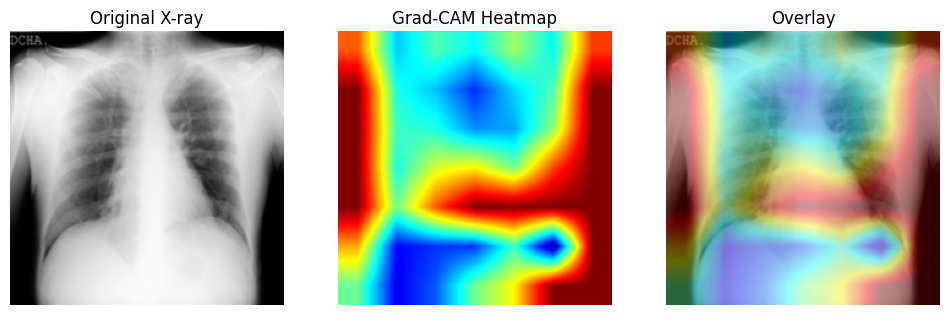

In [41]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original X-ray")
plt.imshow(original)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()


In [42]:
prob = model.predict(input_tensor)[0][0]

threshold = 0.238

if prob >= threshold:
    prediction = "COVID"
else:
    prediction = "Normal"

print(f"Model probability: {prob:.3f}")
print(f"Prediction: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Model probability: 0.240
Prediction: COVID
